<center> <H1>Stage E Assessment - Winter '23 </H1> </center>

<center> <H4> by </H4> </center>

<center> <H3> Yusuf Okunlola </H3> </center>

### Time series forecasting models for measurements of electricity prices

In this quiz, we’ll explore and build time series forecasting models for measurements of electricity prices  of a District given the total amount of Electricity consumed in that District from 2010 to 2021.

Data Set Information:

The archive contains 92,016 measurements of electricity data gathered between September 2010 and February 2021.

Data Source: https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast

The dataset is sampled on an hourly basis. It has the following features:

- FullDate: Date in format yyyy-mm-dd  hh:mm:ss
- ElecPrice: Prices of electricity charged in Kw per hour
- Gas Price: power generated was done via a gas power plant, gas price is the price of gas at time-T
- SysLoad: Total Load on system or Power consumed at time-T 
- Tmax: maximum temperature at time-T

In [45]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn import metrics
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose as SDecompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# load dataset

# df = pd.read_csv('https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv') # online path

df = pd.read_csv("dataset/Time_series_analysis_and_forecast_DATASET.csv") # local path

print("Data imported successfully")

Data imported successfully


In [3]:
# inspect dataframe by printing out the first 5 rows
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
# check the shape of the dataset i.e. the number of rows and columns
df.shape

(92016, 5)

In [5]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [6]:
# descriptive statistics of the dataset
df.describe()

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


In [7]:
#check for missing values
df.isnull().values.any()

False

In [8]:
#convert column to datetime
df["FullDate"] = pd.to_datetime(df["FullDate"]) 
df.set_index("FullDate", inplace= True) 

In [9]:
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [10]:
# Upsample to daily data points
df_daily = df.resample('D').sum()

print('The daily dataset shape is: ', df_daily.shape)
df_daily.head()

The daily dataset shape is:  (3834, 4)


,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


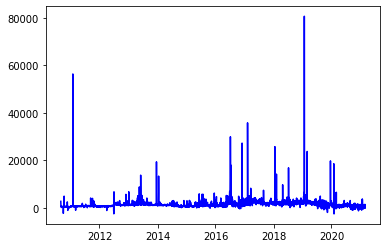

In [11]:
# Plotting the daily sampled data for ElecPrice
daily_ElecPrice = (df_daily['ElecPrice'])
plt.plot(daily_ElecPrice , 'blue')

In [12]:
df_daily.reset_index(inplace=True) # resetting index column
df_daily.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [47]:
# ADF test for 'SysLoad'
adf_result = adfuller(df_daily['SysLoad'])
print(f'ADF Statistic: {adf_result[ 0 ]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
 print(f'{k} : {v}')

ADF Statistic: -3.690158988836652 
p-value: 0.004253725504574031 
No. of lags used: 30 
No. of observations used : 3803 
Critical Values:
 1% : -3.432070672988693 
 5% : -2.8623002987378547 
 10% : -2.567174716967499 


In [50]:
# ADF test for 'ElecPrice'
adf_result = adfuller(df_daily['ElecPrice'])
print(f'ADF Statistic: {adf_result[ 0 ]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
 print(f'{k} : {v}')

ADF Statistic: -8.269053866873815 
p-value: 4.848817773711248e-13 
No. of lags used: 20 
No. of observations used : 3813 
Critical Values:
 1% : -3.432066157296446 
 5% : -2.8622983040036005 
 10% : -2.5671736550459663 


In [51]:
# ADF test for 'GasPrice'
adf_result = adfuller(df_daily['GasPrice'])
print(f'ADF Statistic: {adf_result[ 0 ]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
 print(f'{k} : {v}')

ADF Statistic: -2.9027666971651773 
p-value: 0.045027212884625675 
No. of lags used: 27 
No. of observations used : 3806 
Critical Values:
 1% : -3.4320693157877544 
 5% : -2.8622996992165364 
 10% : -2.5671743978048323 


In [13]:
# Selecting ElecPrice column for univariate time series modelling
daily_data = df_daily[["FullDate","ElecPrice"]]
daily_data = daily_data.rename(columns={ "FullDate" : "ds" , "ElecPrice" : "y" }) # renaming columns
daily_data.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [14]:
# obtain the benchmark the dataset split into train and test
daily_data.loc[2757]

ds    2018-03-20 00:00:00
y                  1833.0
Name: 2757, dtype: object

In [15]:
# Splitting the dataset into train and test sets respectively according to the quiz instructions
df_train = daily_data.loc[daily_data["ds"]<"2018-03-20"] # first 2757 days is train set
df_test  = daily_data.loc[daily_data["ds"]>="2018-03-20"]

In [16]:
df_train.shape, df_test.shape

((2757, 2), (1077, 2))

In [17]:
# Time series with Facebook Prophet

from prophet import Prophet 

model = Prophet(daily_seasonality=True)
model.fit(df_train)

15:28:47 - cmdstanpy - INFO - Chain [1] start processing
15:28:48 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Predicting the values of the test set after dropping the 'y' column
forecast = model.predict(df_test.drop(columns="y"))
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,4206.989845,189.216893,5020.043647,4206.989845,4206.989845,-1677.171061,-1677.171061,-1677.171061,-1521.543549,...,9.736439,9.736439,9.736439,-165.363951,-165.363951,-165.363951,0.0,0.0,0.0,2529.818784
1,2018-03-21,4207.790215,202.487461,5112.146058,4207.790215,4207.790215,-1524.654906,-1524.654906,-1524.654906,-1521.543549,...,159.361114,159.361114,159.361114,-162.472471,-162.472471,-162.472471,0.0,0.0,0.0,2683.135309
2,2018-03-22,4208.590584,295.226815,5171.502567,4208.590584,4208.590584,-1426.441026,-1426.441026,-1426.441026,-1521.543549,...,257.119713,257.119713,257.119713,-162.017190,-162.017190,-162.017190,0.0,0.0,0.0,2782.149558
3,2018-03-23,4209.390953,260.232618,4880.303940,4209.390953,4209.390953,-1635.099686,-1635.099686,-1635.099686,-1521.543549,...,50.276083,50.276083,50.276083,-163.832221,-163.832221,-163.832221,0.0,0.0,0.0,2574.291267
4,2018-03-24,4210.191322,-111.277974,4654.477411,4210.191322,4210.191322,-1960.673064,-1960.673064,-1960.673064,-1521.543549,...,-271.454278,-271.454278,-271.454278,-167.675237,-167.675237,-167.675237,0.0,0.0,0.0,2249.518258


In [19]:
# Time Series Evaluation Metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [22]:
# Computing the time series evaluation 
timeseries_evaluation_metrics_func(df_test.y, forecast.yhat)

MSE is : 10307136.050070403
MAE is : 1735.7882745938723
RMSE is : 3210.4728701657646
MAPE is : 545.7818340648296
R2 is : -0.24585861269141862



In [23]:
# Computing the MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = df_test['y']
pred = forecast['yhat']

mape(actual, pred)

545.7818340648296

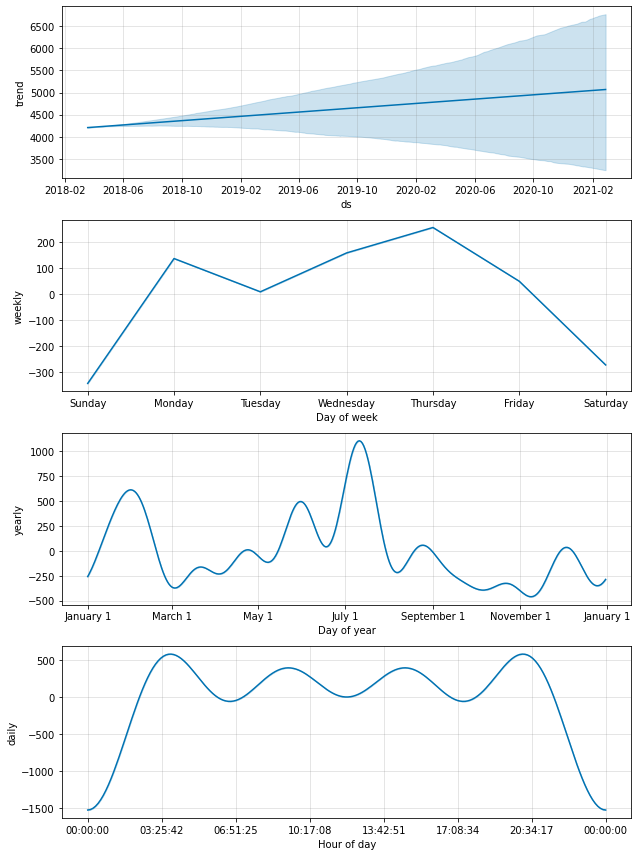

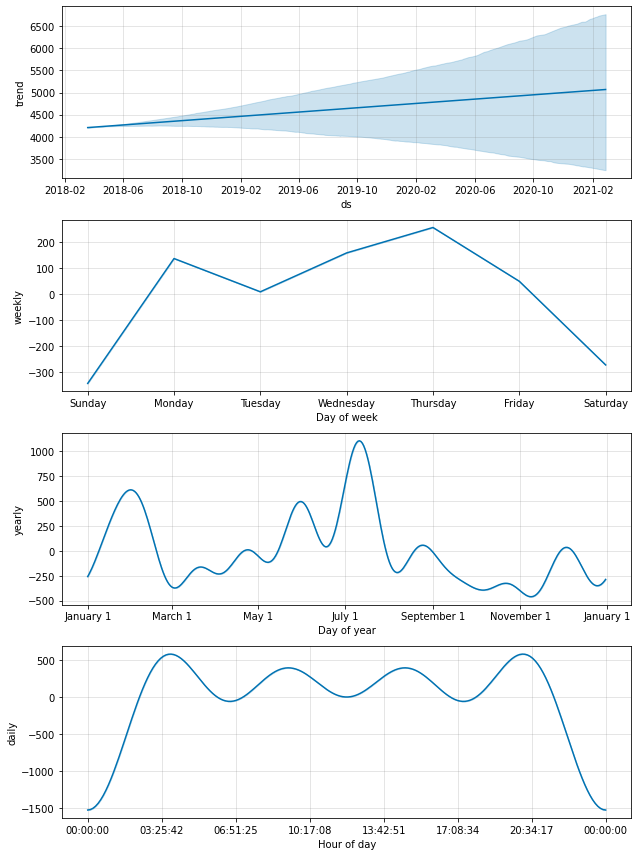

In [24]:
# Plotting the components of the forecast
model.plot_components(forecast)

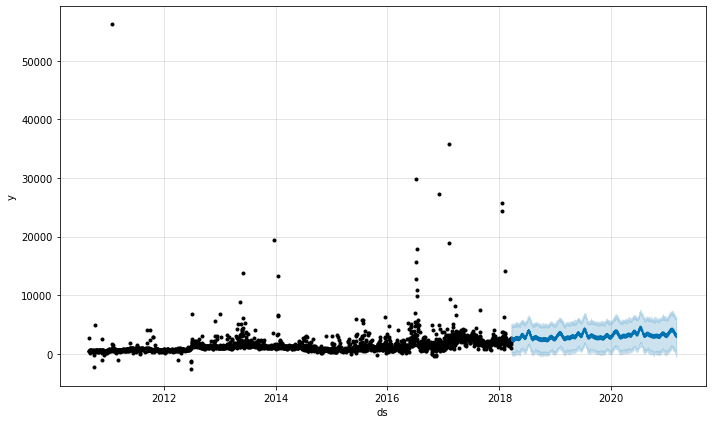

In [25]:
# Plotting the forecasted values
model.plot(forecast)
plt.show()

### Multivariate Time series forecasting with Facebook Prophet

In [26]:
# we make use of our univariate dataset
daily_data.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [27]:
# add variables to the dataset
daily_data["add1"] = df_daily['SysLoad']
daily_data["add2"] = df_daily['Tmax']
daily_data["add3"] = df_daily['GasPrice']

In [28]:
daily_data.head()

,ds,y,add1,add2,add3
0,2010-09-01,2751.700,41565.380,379.2,88.56
1,2010-09-02,570.810,38898.990,369.6,88.56
2,2010-09-03,504.975,41665.760,439.2,106.80
3,2010-09-04,502.275,35638.085,328.8,81.36
4,2010-09-05,500.555,35611.410,357.6,106.80


In [29]:
# Train and test sets similar to the previous univariate model
df_train = daily_data.loc[daily_data["ds"]<"2018-03-20"]
df_test  = daily_data.loc[daily_data["ds"]>="2018-03-20"]

In [30]:
# instantiate the Prophet model
m = Prophet()

# Adding the other independent variables as regressors
m.add_regressor('add1')
m.add_regressor('add2')
m.add_regressor('add3')

# fit the model
m.fit(df_train)

15:30:12 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Predicting the test set after the 'y' column has been temporarily dropped
multi_forecast = m.predict(df_test.drop(columns="y"))

In [32]:
multi_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,1876.419809,-99.828531,4359.767890,1876.419809,1876.419809,-857.602000,-857.602000,-857.602000,0.232867,...,-84.577019,-84.577019,-84.577019,-39.114417,-39.114417,-39.114417,0.0,0.0,0.0,1993.804660
1,2018-03-21,1877.129722,-269.726149,4136.939969,1877.129722,1877.129722,-1027.858036,-1027.858036,-1027.858036,0.230104,...,42.473061,42.473061,42.473061,-29.780362,-29.780362,-29.780362,0.0,0.0,0.0,1985.047580
2,2018-03-22,1877.839634,668.469394,5162.442296,1877.839634,1877.839634,-215.266153,-215.266153,-215.266153,0.216717,...,145.508591,145.508591,145.508591,-24.703778,-24.703778,-24.703778,0.0,0.0,0.0,2906.448102
3,2018-03-23,1878.549547,546.632071,4611.759375,1878.549547,1878.549547,-275.290109,-275.290109,-275.290109,0.208854,...,-44.414938,-44.414938,-44.414938,-23.743630,-23.743630,-23.743630,0.0,0.0,0.0,2590.699311
4,2018-03-24,1879.259459,-826.325512,3731.299666,1879.259459,1879.259459,-1077.974790,-1077.974790,-1077.974790,0.206942,...,-117.401450,-117.401450,-117.401450,-26.649465,-26.649465,-26.649465,0.0,0.0,0.0,1443.151863


In [33]:
# Computing the time series evaluation 
timeseries_evaluation_metrics_func(df_test.y, multi_forecast.yhat)

MSE is : 7357577.901758181
MAE is : 1002.0019763507588
RMSE is : 2712.4855578893284
MAPE is : 236.35518912842159
R2 is : 0.11066451893871398



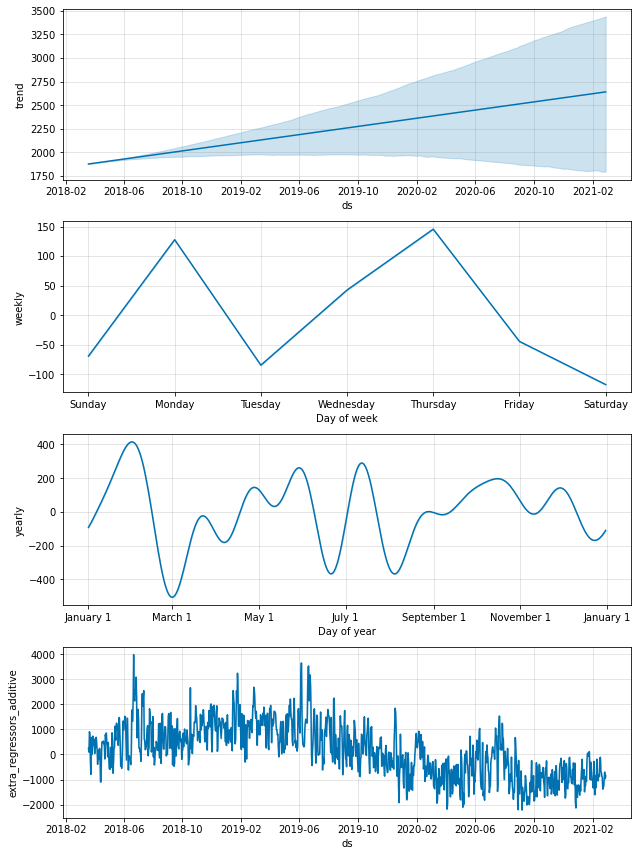

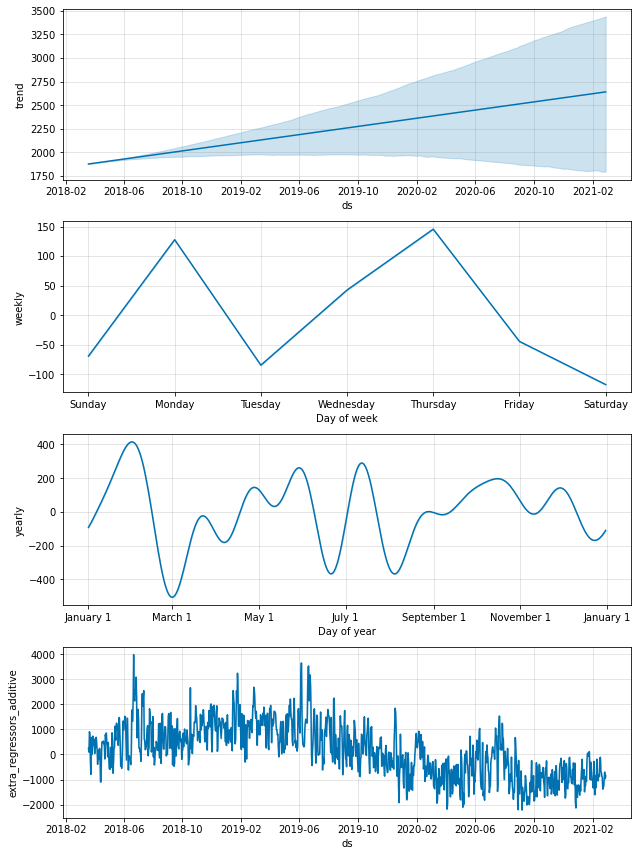

In [34]:
# Plotting the components of the multivariate forecast
m.plot_components(multi_forecast)

In [38]:
# Drop 'Tmax' column i.e. "add2" from the dataset

# we make use of our univariate dataset
daily_data.drop(columns="add2", inplace=True)

In [39]:
daily_data.head()

,ds,y,add1,add3
0,2010-09-01,2751.700,41565.380,88.56
1,2010-09-02,570.810,38898.990,88.56
2,2010-09-03,504.975,41665.760,106.80
3,2010-09-04,502.275,35638.085,81.36
4,2010-09-05,500.555,35611.410,106.80


In [40]:
# Train and test sets similar to the previous univariate model
df_train = daily_data.loc[daily_data["ds"]<"2018-03-20"]
df_test  = daily_data.loc[daily_data["ds"]>="2018-03-20"]

In [41]:
# instantiate the Prophet model
m = Prophet()

# Adding the other independent variables as regressors
m.add_regressor('add1')
m.add_regressor('add3')

# fit the model
m.fit(df_train)

15:35:34 - cmdstanpy - INFO - Chain [1] start processing
15:35:35 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Predicting the test set after the 'y' column has been temporarily dropped
multi_forecast = m.predict(df_test.drop(columns="y"))

In [43]:
multi_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add3,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,1859.032817,-241.710986,4134.503988,1859.032817,1859.032817,-856.111116,-856.111116,-856.111116,1100.683302,...,-84.302103,-84.302103,-84.302103,-38.746725,-38.746725,-38.746725,0.0,0.0,0.0,1980.556174
1,2018-03-21,1859.704951,-343.874561,4139.374881,1859.704951,1859.704951,-1026.071174,-1026.071174,-1026.071174,1125.140699,...,42.662994,42.662994,42.662994,-29.508094,-29.508094,-29.508094,0.0,0.0,0.0,1971.929377
2,2018-03-22,1860.377085,632.646339,5151.518884,1860.377085,1860.377085,-214.891927,-214.891927,-214.891927,1125.140699,...,145.270010,145.270010,145.270010,-24.521939,-24.521939,-24.521939,0.0,0.0,0.0,2891.373929
3,2018-03-23,1861.049220,363.274831,4844.747070,1861.049220,1861.049220,-274.811535,-274.811535,-274.811535,1057.539751,...,-44.104945,-44.104945,-44.104945,-23.646490,-23.646490,-23.646490,0.0,0.0,0.0,2576.026000
4,2018-03-24,1861.721354,-927.952896,3557.350339,1861.721354,1861.721354,-1076.100803,-1076.100803,-1076.100803,787.311911,...,-117.785133,-117.785133,-117.785133,-26.630723,-26.630723,-26.630723,0.0,0.0,0.0,1428.516606


In [44]:
# Computing the time series evaluation 
timeseries_evaluation_metrics_func(df_test.y, multi_forecast.yhat)

MSE is : 7310409.737928011
MAE is : 973.3485175208367
RMSE is : 2703.7769393809117
MAPE is : 228.18212681592453
R2 is : 0.11636589542847664

